# NB01: Foundation v2.0

**Constraint-Based Architectural NCA - Step B**

**Version:** 2.0  
**Date:** December 2025  
**Purpose:** Revised foundation with correct representations

---

## Key Changes from Step A (v1.x)

| Aspect | v1.x (Wrong) | v2.0 (Correct) |
|--------|--------------|----------------|
| Walkable | Grown solid channel | Computed void property |
| Ground contact | Free | Restricted to anchor zones |
| Channel 3 | Unused | Anchor zones (frozen) |
| Channel 5 | Walkable (grown) | Surface type (grown) |

## Aims

1. Implement revised 8-channel architecture
2. Implement 3D Sobel perception with replicate padding
3. Implement NCA model (no walkable channel)
4. Implement UrbanSceneGenerator with anchor zones
5. Implement street void computation utilities
6. Implement visualization showing void protection
7. Verify forward pass and gradient flow

## Success Criteria

- Model produces correct shape [B, 8, 32, 32, 32]
- Anchor zones correctly generated
- Street void computation works
- Visualization shows void/violation clearly
- Gradients flow through all parameters

---

## 1. Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = '/content/drive/MyDrive/Constraint-NCA'
print(f'Project root: {PROJECT_ROOT}')

Mounted at /content/drive
Project root: /content/drive/MyDrive/Constraint-NCA


In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from typing import Dict, Tuple, Optional, List
import json
import os

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Device: cuda
GPU: Tesla T4


In [3]:
# Set seeds for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
print('Seeds set')

Seeds set


## 2. Configuration (Step B - Revised)

In [4]:
# Step B Configuration
CONFIG = {
    # Grid
    'grid_size': 32,

    # Channels (8 total: 4 frozen + 4 grown)
    'n_channels': 8,
    'n_frozen': 4,
    'n_grown': 4,

    # Channel indices - FROZEN (scene context)
    'ch_ground': 0,      # Ground plane
    'ch_existing': 1,    # Existing buildings
    'ch_access': 2,      # Access points
    'ch_anchors': 3,     # Anchor zones (NEW - allowed ground contact)

    # Channel indices - GROWN (by NCA)
    'ch_structure': 4,   # Generated structure
    'ch_surface': 5,     # Surface type indicator (replaces walkable)
    'ch_alive': 6,       # Cell alive state
    'ch_hidden': 7,      # Hidden state

    # Network architecture
    'hidden_dim': 96,
    'update_scale': 0.1,
    'fire_rate': 0.65,
    'noise_std': 0.02,        # NEW: small noise injection
    'z_taper_strength': 0.4,  # NEW: height taper
    'z_taper_floor': 0.4,     # NEW: minimum taper weight

    # Initialization
    'xavier_gain': 0.5,
    'structure_bias': 0.0,
    'surface_bias': 0.0,

    # Training (defaults)
    'lr_initial': 2e-3,
    'batch_size': 4,
    'grad_clip': 1.0,

    # Street void parameters
    'street_levels': 2,           # How many z-levels define "street" (0 and 1)
    'anchor_budget_ratio': 0.10,  # Max 10% of street can be anchors
}

print('Step B Configuration:')
print(f"  Grid size: {CONFIG['grid_size']}³")
print(f"  Channels: {CONFIG['n_channels']} ({CONFIG['n_frozen']} frozen + {CONFIG['n_grown']} grown)")
print(f"  Street levels: z=0 to z={CONFIG['street_levels']-1}")
print(f"  Anchor budget: {CONFIG['anchor_budget_ratio']*100:.0f}% of street area")

Step B Configuration:
  Grid size: 32³
  Channels: 8 (4 frozen + 4 grown)
  Street levels: z=0 to z=1
  Anchor budget: 10% of street area


In [5]:
# Save configuration
os.makedirs(PROJECT_ROOT, exist_ok=True)
os.makedirs(f'{PROJECT_ROOT}/step_b', exist_ok=True)
os.makedirs(f'{PROJECT_ROOT}/step_b/checkpoints', exist_ok=True)
os.makedirs(f'{PROJECT_ROOT}/step_b/logs', exist_ok=True)

config_path = f'{PROJECT_ROOT}/config_step_b.json'
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=2)
print(f'Configuration saved to {config_path}')

Configuration saved to /content/drive/MyDrive/Constraint-NCA/config_step_b.json


## 3. Perception Module

3D Sobel filters with **replicate padding** to avoid boundary artifacts.

In [6]:
class Perceive3D(nn.Module):
    """3D Sobel perception for NCA.

    Uses REPLICATE padding to avoid boundary artifacts that caused
    systematic growth bias in Step A.

    Output: 4 * n_channels features (identity + 3 gradients per channel)
    """

    def __init__(self, n_channels: int = 8):
        super().__init__()
        self.n_channels = n_channels

        # Create Sobel kernels
        sobel_x = self._create_sobel_kernel('x')
        sobel_y = self._create_sobel_kernel('y')
        sobel_z = self._create_sobel_kernel('z')
        identity = self._create_identity_kernel()

        # Stack kernels: [4, 3, 3, 3]
        kernels = torch.stack([identity, sobel_x, sobel_y, sobel_z], dim=0)
        self.register_buffer('kernels', kernels)

    def _create_sobel_kernel(self, direction: str) -> torch.Tensor:
        """Create 3D Sobel kernel for gradient in given direction."""
        derivative = torch.tensor([-1., 0., 1.])
        smoothing = torch.tensor([1., 2., 1.])

        if direction == 'x':  # Gradient along width
            kernel = torch.einsum('i,j,k->ijk', smoothing, smoothing, derivative)
        elif direction == 'y':  # Gradient along height
            kernel = torch.einsum('i,j,k->ijk', smoothing, derivative, smoothing)
        elif direction == 'z':  # Gradient along depth
            kernel = torch.einsum('i,j,k->ijk', derivative, smoothing, smoothing)

        return kernel / 16.0  # Normalize

    def _create_identity_kernel(self) -> torch.Tensor:
        """Create identity kernel (center = 1, rest = 0)."""
        kernel = torch.zeros(3, 3, 3)
        kernel[1, 1, 1] = 1.0
        return kernel

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Apply perception filters to input.

        Args:
            x: Input tensor [B, C, D, H, W]

        Returns:
            Perception tensor [B, C*4, D, H, W]
        """
        B, C, D, H, W = x.shape

        # REPLICATE padding to avoid boundary artifacts
        x_padded = F.pad(x, (1, 1, 1, 1, 1, 1), mode='replicate')

        outputs = []
        for k in range(4):  # identity, sobel_x, sobel_y, sobel_z
            # Expand kernel for depthwise convolution
            kernel = self.kernels[k:k+1].unsqueeze(0).expand(C, 1, 3, 3, 3)
            out = F.conv3d(x_padded, kernel, padding=0, groups=C)
            outputs.append(out)

        return torch.cat(outputs, dim=1)


# Test perception
print('Testing Perceive3D...')
perceive = Perceive3D(CONFIG['n_channels']).to(device)
test_input = torch.randn(1, CONFIG['n_channels'], 32, 32, 32, device=device)
test_output = perceive(test_input)
print(f'  Input shape:  {test_input.shape}')
print(f'  Output shape: {test_output.shape}')
print(f'  Expected:     [1, {CONFIG["n_channels"]*4}, 32, 32, 32]')
assert test_output.shape == (1, CONFIG['n_channels']*4, 32, 32, 32)
print('  ✓ Perception module working')

Testing Perceive3D...
  Input shape:  torch.Size([1, 8, 32, 32, 32])
  Output shape: torch.Size([1, 32, 32, 32, 32])
  Expected:     [1, 32, 32, 32, 32]
  ✓ Perception module working


## 4. NCA Model (Step B - Revised)

Key changes from Step A:
- No walkable channel gating
- Exclusion mask for existing buildings
- Structure only grows in allowed zones

In [7]:
class UrbanPavilionNCA(nn.Module):
    """Neural Cellular Automaton for urban pavilion generation.

    Step B version:
    - No walkable channel (walkability computed from void)
    - Structure masked to avoid existing buildings
    - Anchor zones define allowed ground contact
    """

    def __init__(self, config: dict):
        super().__init__()
        self.config = config

        n_channels = config['n_channels']
        hidden_dim = config['hidden_dim']
        perception_dim = n_channels * 4  # From Perceive3D
        n_grown = config['n_grown']

        # Perception module
        self.perceive = Perceive3D(n_channels)

        # Update network: perception -> hidden -> hidden -> grown channels
        self.update_net = nn.Sequential(
            nn.Conv3d(perception_dim, hidden_dim, 1),
            nn.ReLU(),
            nn.Conv3d(hidden_dim, hidden_dim, 1),
            nn.ReLU(),
            nn.Conv3d(hidden_dim, n_grown, 1),
        )

        self._init_weights()

    def _init_weights(self):
        """Initialize network weights."""
        gain = self.config['xavier_gain']
        for m in self.update_net:
            if isinstance(m, nn.Conv3d):
                nn.init.xavier_uniform_(m.weight, gain=gain)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        # Set output biases
        last_layer = self.update_net[-1]
        with torch.no_grad():
            last_layer.bias[0] = self.config['structure_bias']
            last_layer.bias[1] = self.config['surface_bias']

    def forward(self, state: torch.Tensor, steps: int = 1) -> torch.Tensor:
        """Run NCA for specified number of steps."""
        for _ in range(steps):
            state = self._step(state)
        return state

    def _step(self, state: torch.Tensor) -> torch.Tensor:
        """Single NCA update step."""
        B, C, D, H, W = state.shape
        cfg = self.config

        # Perceive neighborhood
        perception = self.perceive(state)

        # Compute updates
        delta = self.update_net(perception)

        # Stochastic update (fire rate)
        if self.training:
            fire_mask = (torch.rand(B, 1, D, H, W, device=state.device) < cfg['fire_rate']).float()
            delta = delta * fire_mask

        # Apply updates to grown channels
        grown_start = cfg['n_frozen']
        grown_new = state[:, grown_start:] + cfg['update_scale'] * delta
        grown_new = torch.clamp(grown_new, 0.0, 1.0)

        # Small negative-only noise to prune weak/strong voxels (training only)
        noise_std = self.config.get('noise_std', 0.0)
        if self.training and noise_std > 0:
            grown_new = grown_new - noise_std * torch.abs(torch.randn_like(grown_new))
            grown_new = torch.clamp(grown_new, 0.0, 1.0)

        # === HARD MASKS ===

        # Get frozen channels
        existing = state[:, cfg['ch_existing']:cfg['ch_existing']+1]

        # Structure cannot exist inside existing buildings
        available_mask = 1.0 - existing

        # Apply mask to structure channel
        struct_new = grown_new[:, 0:1] * available_mask
        # Enforce anchor legality at street level
        if 'ch_anchors' in cfg:
            anchors = state[:, cfg['ch_anchors']:cfg['ch_anchors']+1]
            street_levels = cfg.get('street_levels', 2)
            legality = torch.ones_like(existing)
            legality = legality * (1 - existing)
            street_mask = torch.zeros_like(legality)
            street_mask[:, :street_levels, :, :] = 1.0
            anchor_mask = anchors.clone()
            anchor_mask[:, street_levels:, :, :] = 1.0
            legality = legality * (anchor_mask + (1 - street_mask))
            legality = torch.clamp(legality, 0, 1)
            struct_new = struct_new * legality


        # Reconstruct grown channels
        grown_masked = torch.cat([
            struct_new,           # structure (masked)
            grown_new[:, 1:],     # surface, alive, hidden (unchanged)
        ], dim=1)

        # Reconstruct full state
        new_state = torch.cat([
            state[:, :grown_start],  # frozen channels unchanged
            grown_masked,             # masked grown channels
        ], dim=1)

        return new_state

    def grow(self, seed: torch.Tensor, steps: int = 50) -> torch.Tensor:
        """Grow structure from seed (inference mode)."""
        self.eval()
        with torch.no_grad():
            return self.forward(seed, steps)


# Test NCA model
print('Testing UrbanPavilionNCA...')
model = UrbanPavilionNCA(CONFIG).to(device)
test_state = torch.zeros(1, CONFIG['n_channels'], 32, 32, 32, device=device)
test_state[:, CONFIG['ch_ground'], 0, :, :] = 1.0  # Ground plane

output = model(test_state, steps=1)
print(f'  Input shape:  {test_state.shape}')
print(f'  Output shape: {output.shape}')
assert output.shape == test_state.shape
print(f'  Parameters: {sum(p.numel() for p in model.parameters()):,}')
print('  ✓ NCA model working')

Testing UrbanPavilionNCA...
  Input shape:  torch.Size([1, 8, 32, 32, 32])
  Output shape: torch.Size([1, 8, 32, 32, 32])
  Parameters: 12,868
  ✓ NCA model working


## 5. Scene Generator (Step B - With Anchor Zones)

Key changes:
- Generates anchor zones (ch_3) defining allowed ground contact
- Anchors placed near access points and along building facades
- Anchor budget enforced

In [8]:
class UrbanSceneGenerator:
    """Generate urban scenes with buildings, access points, and anchor zones.

    Step B version:
    - Generates anchor zones (frozen channel) defining allowed ground contact
    - Anchor budget limits total anchor area
    - Access points fully randomized across valid locations
    """

    def __init__(self, config: dict):
        self.config = config
        self.G = config['grid_size']
        self.C = config['n_channels']

    def generate(self, difficulty: str = 'easy',
                 device: str = 'cuda') -> Tuple[torch.Tensor, dict]:
        """Generate a complete urban scene.

        Returns:
            state: Initial state tensor [1, C, G, G, G]
            metadata: Scene information dict
        """
        G = self.G
        cfg = self.config

        # Initialize state
        state = torch.zeros(1, self.C, G, G, G, device=device)

        # Set ground plane (ch_0)
        state[:, cfg['ch_ground'], 0, :, :] = 1.0

        # Get difficulty parameters
        params = self._get_difficulty_params(difficulty)

        # Place buildings (ch_1)
        building_info = self._place_buildings(state, params)

        # Place access points (ch_2)
        access_info = self._place_access_points(state, params, building_info)

        # Generate anchor zones (ch_3) - NEW in Step B
        anchor_info = self._generate_anchor_zones(state, params, building_info, access_info)

        metadata = {
            'difficulty': difficulty,
            'buildings': building_info,
            'access_points': access_info,
            'anchor_zones': anchor_info,
            'gap_width': params['gap_width'],
        }

        return state, metadata

    def _get_difficulty_params(self, difficulty: str) -> dict:
        """Get parameters for scene difficulty."""
        G = self.G

        if difficulty == 'easy':
            return {
                'n_buildings': 2,
                'height_range': (12, 16),
                'height_variance': False,
                'width_range': (8, 12),
                'gap_width': random.randint(14, 18),  # Wide gap
                'n_ground_access': 1,
                'n_elevated_access': 1,
                'anchor_budget': 0.10,  # 10% of street
            }
        elif difficulty == 'medium':
            return {
                'n_buildings': 2,
                'height_range': (10, 20),
                'height_variance': True,
                'width_range': (6, 10),
                'gap_width': random.randint(10, 14),
                'n_ground_access': random.randint(1, 2),
                'n_elevated_access': random.randint(1, 2),
                'anchor_budget': 0.07,  # 7% of street
            }
        elif difficulty == 'hard':
            return {
                'n_buildings': random.randint(2, 4),
                'height_range': (8, 24),
                'height_variance': True,
                'width_range': (5, 8),
                'gap_width': random.randint(6, 10),  # Narrow gap
                'n_ground_access': random.randint(2, 3),
                'n_elevated_access': random.randint(2, 3),
                'anchor_budget': 0.05,  # 5% of street
            }
        else:
            raise ValueError(f"Unknown difficulty: {difficulty}")

    def _place_buildings(self, state: torch.Tensor, params: dict) -> list:
        """Place existing buildings in the scene."""
        G = self.G
        ch = self.config['ch_existing']
        buildings = []
        gap_width = params['gap_width']
        gap_center = G // 2

        # Building 1 (left of gap)
        w1 = random.randint(*params['width_range'])
        d1 = random.randint(G//2, G-2)
        h1 = random.randint(*params['height_range'])
        x1_end = gap_center - gap_width // 2
        x1_start = max(0, x1_end - w1)

        state[:, ch, :h1, :d1, x1_start:x1_end] = 1.0
        buildings.append({
            'x': (x1_start, x1_end),
            'y': (0, d1),
            'z': (0, h1),
            'gap_facing_x': x1_end,
            'side': 'left'
        })

        # Building 2 (right of gap)
        w2 = random.randint(*params['width_range'])
        d2 = random.randint(G//2, G-2)
        h2 = h1 if not params['height_variance'] else random.randint(*params['height_range'])
        x2_start = gap_center + gap_width // 2
        x2_end = min(G, x2_start + w2)

        state[:, ch, :h2, :d2, x2_start:x2_end] = 1.0
        buildings.append({
            'x': (x2_start, x2_end),
            'y': (0, d2),
            'z': (0, h2),
            'gap_facing_x': x2_start,
            'side': 'right'
        })

        return buildings

    def _place_access_points(self, state: torch.Tensor, params: dict,
                             buildings: list) -> list:
        """Place access points in the scene."""
        G = self.G
        ch = self.config['ch_access']
        access_points = []

        n_ground = params.get('n_ground_access', 1)
        n_elevated = params.get('n_elevated_access', 1)

        # Compute gap boundaries
        left_buildings = [b for b in buildings if b['side'] == 'left']
        right_buildings = [b for b in buildings if b['side'] == 'right']

        gap_x_min = max(b['gap_facing_x'] for b in left_buildings) if left_buildings else 0
        gap_x_max = min(b['gap_facing_x'] for b in right_buildings) if right_buildings else G

        # Ground access points: in the gap on the ground
        for i in range(n_ground):
            x = random.randint(gap_x_min + 1, gap_x_max - 3)
            y = random.randint(0, G - 3)
            z = 0

            state[:, ch, z:z+2, y:y+2, x:x+2] = 1.0
            access_points.append({'x': x, 'y': y, 'z': z, 'type': 'ground'})

        # Elevated access points: on building facades facing the gap
        for i in range(n_elevated):
            building = random.choice(buildings)
            bx_start, bx_end = building['x']
            by_start, by_end = building['y']
            bz_max = building['z'][1]
            is_left = building['side'] == 'left'

            # Random height on facade (not ground, not roof)
            z = random.randint(3, max(4, bz_max - 2))

            # Random depth along facade
            y = random.randint(by_start, min(by_end - 2, by_start + G//3))

            # X: just outside facade facing gap
            if is_left:
                x = bx_end  # Right edge of left building
            else:
                x = bx_start - 2  # Left edge of right building

            x = max(0, min(G - 2, x))
            y = max(0, min(G - 2, y))
            z = max(1, min(G - 2, z))

            state[:, ch, z:z+2, y:y+2, x:x+2] = 1.0
            access_points.append({'x': x, 'y': y, 'z': z, 'type': 'elevated'})

        return access_points

    def _generate_anchor_zones(self, state: torch.Tensor, params: dict,
                               buildings: list, access_points: list) -> dict:
        """Generate anchor zones where structure is allowed to touch ground.

        Anchor zones are placed:
        1. Around ground-level access points (access projection)
        2. Along building facades facing the gap (thin strip)

        Total anchor area is limited by anchor_budget.
        """
        G = self.G
        ch = self.config['ch_anchors']
        street_levels = self.config['street_levels']

        # Compute available street area (ground minus buildings)
        existing = state[:, self.config['ch_existing'], 0, :, :]
        street_mask = 1.0 - existing
        total_street_area = street_mask.sum().item()

        # Anchor budget
        max_anchor_area = int(total_street_area * params['anchor_budget'])
        current_anchor_area = 0

        # Initialize anchor channel
        anchors = torch.zeros(1, 1, G, G, G, device=state.device)

        # 1. Access point projections (small areas around ground access)
        access_anchor_size = 3  # 3x3 footprint per access point
        for ap in access_points:
            if ap['type'] == 'ground':
                x, y = ap['x'], ap['y']
                x_start = max(0, x - 1)
                x_end = min(G, x + access_anchor_size)
                y_start = max(0, y - 1)
                y_end = min(G, y + access_anchor_size)

                # Only at street levels
                for z in range(street_levels):
                    anchors[:, 0, z, y_start:y_end, x_start:x_end] = 1.0

                current_anchor_area += (x_end - x_start) * (y_end - y_start)

        # 2. Building facade strips (1-voxel wide along gap-facing facades)
        facade_strip_width = 1
        for building in buildings:
            by_start, by_end = building['y']
            gap_x = building['gap_facing_x']
            is_left = building['side'] == 'left'

            # Strip along facade
            if is_left:
                x_start, x_end = gap_x, gap_x + facade_strip_width
            else:
                x_start, x_end = gap_x - facade_strip_width, gap_x

            x_start = max(0, x_start)
            x_end = min(G, x_end)

            # Check budget
            strip_area = (x_end - x_start) * (by_end - by_start)
            if current_anchor_area + strip_area <= max_anchor_area:
                for z in range(street_levels):
                    anchors[:, 0, z, by_start:by_end, x_start:x_end] = 1.0
                current_anchor_area += strip_area

        # Mask out areas inside buildings (anchors only on street)
        for z in range(street_levels):
            anchors[:, 0, z, :, :] *= street_mask

        # Write to state
        state[:, ch:ch+1, :, :, :] = anchors

        # Compute final anchor area
        final_anchor_area = (anchors > 0.5).sum().item()

        return {
            'total_area': final_anchor_area,
            'budget': max_anchor_area,
            'budget_ratio': params['anchor_budget'],
            'street_area': total_street_area,
        }

    def batch(self, difficulty: str, batch_size: int, device: str) -> torch.Tensor:
        """Generate a batch of scenes."""
        scenes = [self.generate(difficulty, device)[0] for _ in range(batch_size)]
        return torch.cat(scenes, dim=0)


# Test scene generator
print('Testing UrbanSceneGenerator (Step B)...')
scene_gen = UrbanSceneGenerator(CONFIG)

for diff in ['easy', 'medium', 'hard']:
    scene, meta = scene_gen.generate(diff, device)
    print(f"\n  {diff.upper()} scene:")
    print(f"    Gap width: {meta['gap_width']}")
    print(f"    Access points: {len(meta['access_points'])}")
    for ap in meta['access_points']:
        print(f"      - {ap['type']}: z={ap['z']}, y={ap['y']}, x={ap['x']}")
    print(f"    Anchor zones:")
    print(f"      - Area: {meta['anchor_zones']['total_area']:.0f} voxels")
    print(f"      - Budget: {meta['anchor_zones']['budget']:.0f} voxels ({meta['anchor_zones']['budget_ratio']*100:.0f}%)")

print('\n  ✓ Scene generator working')

Testing UrbanSceneGenerator (Step B)...

  EASY scene:
    Gap width: 14
    Access points: 2
      - ground: z=0, y=23, x=12
      - elevated: z=11, y=1, x=9
    Anchor zones:
      - Area: 124 voxels
      - Budget: 63 voxels (10%)

  MEDIUM scene:
    Gap width: 14
    Access points: 3
      - ground: z=0, y=17, x=10
      - ground: z=0, y=22, x=13
      - elevated: z=6, y=7, x=21
    Anchor zones:
      - Area: 96 voxels
      - Budget: 52 voxels (7%)

  HARD scene:
    Gap width: 8
    Access points: 4
      - ground: z=0, y=2, x=13
      - ground: z=0, y=3, x=16
      - elevated: z=16, y=5, x=18
      - elevated: z=15, y=0, x=18
    Anchor zones:
      - Area: 58 voxels
      - Budget: 37 voxels (5%)

  ✓ Scene generator working


## 6. Street Void Computation Utilities

Functions to compute street void metrics:
- Street void ratio (how much of street is empty)
- Street connectivity (is void connected across scene)
- Anchor compliance (is structure only in anchor zones at ground level)

In [9]:
def compute_street_zone(state: torch.Tensor, config: dict) -> torch.Tensor:
    """Compute the street zone mask.

    Street zone = ground level voxels that are:
    - NOT inside existing buildings
    - At z < street_levels

    Returns:
        Binary mask [B, D, H, W] where D = street_levels
    """
    street_levels = config['street_levels']
    existing = state[:, config['ch_existing'], :street_levels, :, :]
    street_zone = 1.0 - existing
    return street_zone


def compute_street_void_ratio(state: torch.Tensor, config: dict) -> torch.Tensor:
    """Compute ratio of street zone that is empty (no structure).

    Returns:
        Void ratio [B] (higher is better, target >70%)
    """
    street_levels = config['street_levels']

    # Get street zone
    street_zone = compute_street_zone(state, config)

    # Get structure at street level
    structure = state[:, config['ch_structure'], :street_levels, :, :]

    # Void = street zone AND NOT structure
    void_mask = street_zone * (1.0 - structure)

    # Compute ratio
    void_ratio = void_mask.sum(dim=(1,2,3)) / (street_zone.sum(dim=(1,2,3)) + 1e-8)

    return void_ratio


def compute_anchor_compliance(state: torch.Tensor, config: dict) -> torch.Tensor:
    """Check if ground-level structure is only in anchor zones.

    Returns:
        Compliance ratio [B] (1.0 = perfect, structure only in anchors)
    """
    street_levels = config['street_levels']

    # Get structure at street level
    structure = state[:, config['ch_structure'], :street_levels, :, :]

    # Get anchor zones
    anchors = state[:, config['ch_anchors'], :street_levels, :, :]

    # Get street zone (exclude buildings)
    street_zone = compute_street_zone(state, config)

    # Structure in street zone
    struct_in_street = structure * street_zone

    # Structure in anchor zones
    struct_in_anchors = structure * anchors

    # Violation = structure in street but NOT in anchors
    violation = struct_in_street * (1.0 - anchors)

    # Compliance = 1 - (violation / total street structure)
    total_struct = struct_in_street.sum(dim=(1,2,3)) + 1e-8
    violation_sum = violation.sum(dim=(1,2,3))

    compliance = 1.0 - (violation_sum / total_struct)

    return compliance


def compute_street_connectivity(state: torch.Tensor, config: dict,
                                iterations: int = 32) -> torch.Tensor:
    """Check if street void is connected across the scene.

    Uses flood-fill from scene edges to check if void forms
    a connected network for circulation.

    Returns:
        Connectivity ratio [B] (1.0 = all void connected)
    """
    street_levels = config['street_levels']
    G = config['grid_size']

    # Get void at street level
    structure = state[:, config['ch_structure'], :street_levels, :, :]
    existing = state[:, config['ch_existing'], :street_levels, :, :]

    # Void = not structure AND not existing
    void_mask = (1.0 - structure) * (1.0 - existing)

    # Initialize flood-fill from edges (people enter from scene boundaries)
    B = state.shape[0]
    connected = torch.zeros_like(void_mask)

    # Seed from all edges at ground level
    connected[:, :, :, 0] = 1.0    # y=0 edge
    connected[:, :, :, -1] = 1.0   # y=max edge
    connected[:, :, 0, :] = 1.0    # x=0 edge
    connected[:, :, -1, :] = 1.0   # x=max edge

    # Mask to void only
    connected = connected * void_mask

    # Flood fill
    for _ in range(iterations):
        # Dilate connected region
        # Reshape for 3D pooling: [B, 1, D, H, W]
        conn_3d = connected.unsqueeze(1)
        dilated = F.max_pool3d(conn_3d, kernel_size=3, stride=1, padding=1)
        dilated = dilated.squeeze(1)

        # Expand only into void
        new_connected = torch.max(connected, dilated * void_mask)

        if torch.allclose(connected, new_connected, atol=1e-5):
            break
        connected = new_connected

    # Connectivity = connected void / total void
    total_void = void_mask.sum(dim=(1,2,3)) + 1e-8
    connected_void = connected.sum(dim=(1,2,3))

    connectivity = connected_void / total_void

    return connectivity


# Test void utilities
print('Testing street void utilities...')
test_scene, test_meta = scene_gen.generate('easy', device)

# Before any structure (should be ~100% void)
void_ratio = compute_street_void_ratio(test_scene, CONFIG)
anchor_comp = compute_anchor_compliance(test_scene, CONFIG)
connectivity = compute_street_connectivity(test_scene, CONFIG)

print(f'  Empty scene (no structure):')
print(f'    Street void ratio: {void_ratio.item()*100:.1f}% (should be ~100%)')
print(f'    Anchor compliance: {anchor_comp.item()*100:.1f}% (N/A - no structure)')
print(f'    Street connectivity: {connectivity.item()*100:.1f}% (should be ~100%)')

# Add some fake structure at ground level
test_with_struct = test_scene.clone()
test_with_struct[:, CONFIG['ch_structure'], 0:2, 10:20, 10:22] = 0.8

void_ratio2 = compute_street_void_ratio(test_with_struct, CONFIG)
anchor_comp2 = compute_anchor_compliance(test_with_struct, CONFIG)
connectivity2 = compute_street_connectivity(test_with_struct, CONFIG)

print(f'\n  With ground structure (outside anchors):')
print(f'    Street void ratio: {void_ratio2.item()*100:.1f}% (should be <100%)')
print(f'    Anchor compliance: {anchor_comp2.item()*100:.1f}% (should be <100% - violation)')
print(f'    Street connectivity: {connectivity2.item()*100:.1f}%')

print('\n  ✓ Street void utilities working')

Testing street void utilities...
  Empty scene (no structure):
    Street void ratio: 100.0% (should be ~100%)
    Anchor compliance: 100.0% (N/A - no structure)
    Street connectivity: 100.0% (should be ~100%)

  With ground structure (outside anchors):
    Street void ratio: 86.2% (should be <100%)
    Anchor compliance: 0.0% (should be <100% - violation)
    Street connectivity: 97.6%

  ✓ Street void utilities working


## 7. Visualization (Step B - Shows Void Protection)

Updated visualization:
- Shows anchor zones
- Highlights street violations (structure outside anchors)
- Shows void connectivity

Testing visualization...

Empty scene (before NCA growth):


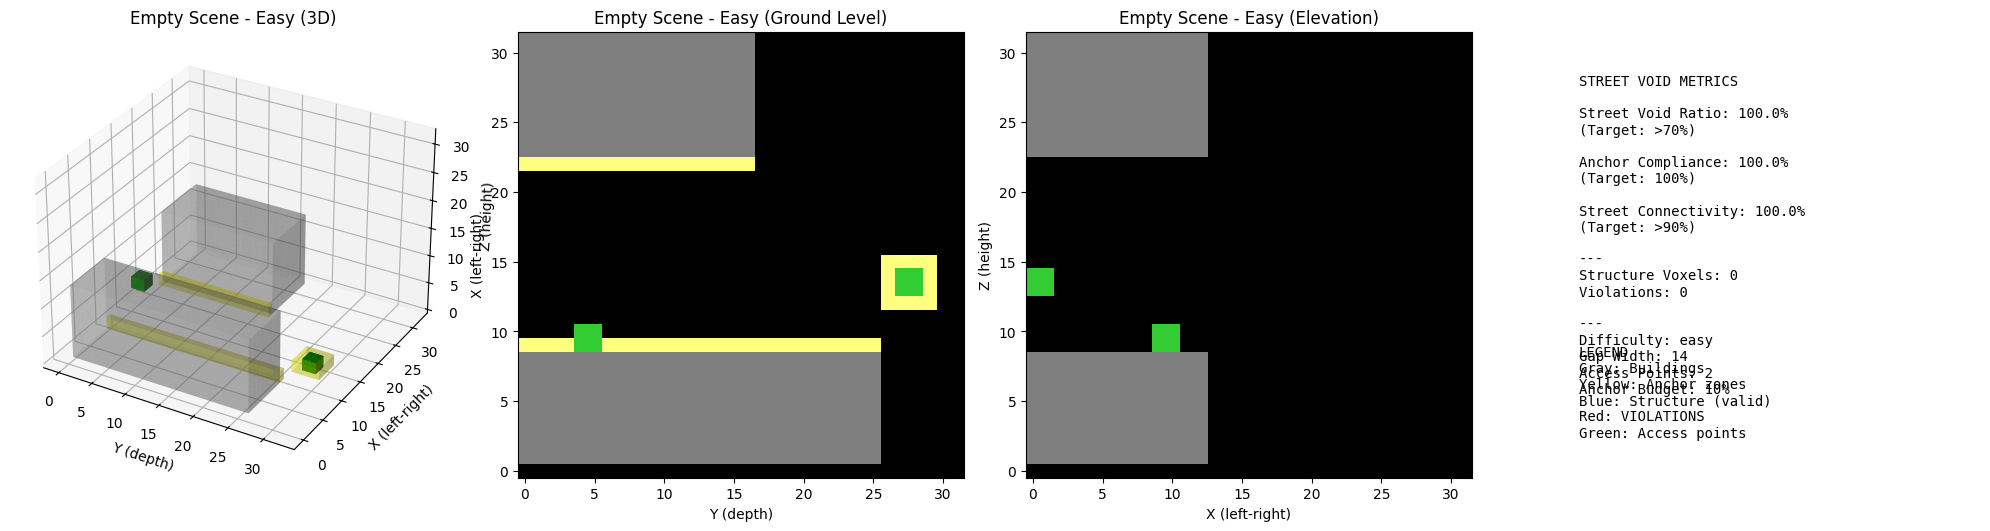

{'void_ratio': 1.0,
 'anchor_compliance': 1.0,
 'connectivity': 1.0,
 'structure_count': np.int64(0),
 'violation_count': np.int64(0)}

In [10]:
def visualize_scene(state: torch.Tensor, config: dict, meta: dict = None,
                    title: str = 'Scene'):
    """Visualize urban scene with void protection indicators.

    Colors:
    - Gray: Existing buildings
    - Blue: Generated structure (valid)
    - Red: Structure violations (outside anchors at ground)
    - Yellow: Anchor zones
    - Green: Access points
    """
    cfg = config
    s = state[0].cpu().numpy()
    G = s.shape[1]
    street_levels = cfg['street_levels']

    # Extract channels
    existing = s[cfg['ch_existing']] > 0.5
    access = s[cfg['ch_access']] > 0.5
    anchors = s[cfg['ch_anchors']] > 0.5
    structure = s[cfg['ch_structure']] > 0.5

    # Compute violations (structure at ground level outside anchors)
    street_struct = structure.copy()
    street_struct[street_levels:, :, :] = False  # Only check street level
    street_struct = street_struct & ~existing  # Not in buildings

    violations = street_struct & ~anchors
    valid_struct = structure & ~violations

    fig = plt.figure(figsize=(20, 5))

    # 3D View
    ax1 = fig.add_subplot(141, projection='3d')

    if existing.any():
        ax1.voxels(existing.transpose(1, 2, 0), facecolors='gray', alpha=0.3, label='Buildings')
    if anchors.any():
        # Only show anchor zones at ground level
        anchor_display = anchors.copy()
        anchor_display[street_levels:, :, :] = False
        if anchor_display.any():
            ax1.voxels(anchor_display.transpose(1, 2, 0), facecolors='yellow', alpha=0.3, label='Anchors')
    if access.any():
        ax1.voxels(access.transpose(1, 2, 0), facecolors='green', alpha=0.9, label='Access')
    if violations.any():
        ax1.voxels(violations.transpose(1, 2, 0), facecolors='red', alpha=0.9, label='VIOLATION')
    if valid_struct.any():
        ax1.voxels(valid_struct.transpose(1, 2, 0), facecolors='royalblue', alpha=0.6, label='Structure')

    ax1.set_title(f'{title} (3D)')
    ax1.set_xlabel('Y (depth)')
    ax1.set_ylabel('X (left-right)')
    ax1.set_zlabel('Z (height)')

    # Plan View (top-down at z=0)
    ax2 = fig.add_subplot(142)
    plan = np.zeros((G, G, 3))

    # Layer order: buildings, anchors, structure, violations, access
    plan[existing[0, :, :]] = [0.5, 0.5, 0.5]  # Gray
    plan[anchors[0, :, :] & ~existing[0, :, :]] = [1.0, 1.0, 0.5]  # Yellow
    plan[valid_struct.max(axis=0)] = [0.2, 0.4, 0.8]  # Blue
    plan[violations[0, :, :]] = [1.0, 0.0, 0.0]  # Red
    plan[access.max(axis=0)] = [0.2, 0.8, 0.2]  # Green

    ax2.imshow(plan.transpose(1, 0, 2), origin='lower')
    ax2.set_title(f'{title} (Ground Level)')
    ax2.set_xlabel('Y (depth)')
    ax2.set_ylabel('X (left-right)')

    # Elevation View (side)
    ax3 = fig.add_subplot(143)
    elev = np.zeros((G, G, 3))
    elev[existing.max(axis=1)] = [0.5, 0.5, 0.5]
    elev[valid_struct.max(axis=1)] = [0.2, 0.4, 0.8]
    elev[violations.max(axis=1)] = [1.0, 0.0, 0.0]
    elev[access.max(axis=1)] = [0.2, 0.8, 0.2]

    ax3.imshow(elev.transpose(1, 0, 2), origin='lower')
    ax3.set_title(f'{title} (Elevation)')
    ax3.set_xlabel('X (left-right)')
    ax3.set_ylabel('Z (height)')

    # Metrics panel
    ax4 = fig.add_subplot(144)
    ax4.axis('off')

    # Compute metrics
    void_ratio = compute_street_void_ratio(state, config).item()
    anchor_comp = compute_anchor_compliance(state, config).item()
    connectivity = compute_street_connectivity(state, config).item()

    struct_count = structure.sum()
    violation_count = violations.sum()

    metrics_text = f"""STREET VOID METRICS

Street Void Ratio: {void_ratio*100:.1f}%
(Target: >70%)

Anchor Compliance: {anchor_comp*100:.1f}%
(Target: 100%)

Street Connectivity: {connectivity*100:.1f}%
(Target: >90%)

---
Structure Voxels: {struct_count}
Violations: {violation_count}
"""

    if meta:
        metrics_text += f"""\n---
Difficulty: {meta['difficulty']}
Gap Width: {meta['gap_width']}
Access Points: {len(meta['access_points'])}
Anchor Budget: {meta['anchor_zones']['budget_ratio']*100:.0f}%
"""

    ax4.text(0.1, 0.9, metrics_text, transform=ax4.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace')

    # Color legend
    legend_text = """LEGEND
Gray: Buildings
Yellow: Anchor zones
Blue: Structure (valid)
Red: VIOLATIONS
Green: Access points
"""
    ax4.text(0.1, 0.3, legend_text, transform=ax4.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace')

    plt.tight_layout()
    plt.show()

    return {
        'void_ratio': void_ratio,
        'anchor_compliance': anchor_comp,
        'connectivity': connectivity,
        'structure_count': struct_count,
        'violation_count': violation_count,
    }


# Test visualization
print('Testing visualization...')
test_scene, test_meta = scene_gen.generate('easy', device)
print('\nEmpty scene (before NCA growth):')
visualize_scene(test_scene, CONFIG, test_meta, 'Empty Scene - Easy')


Medium difficulty scene:


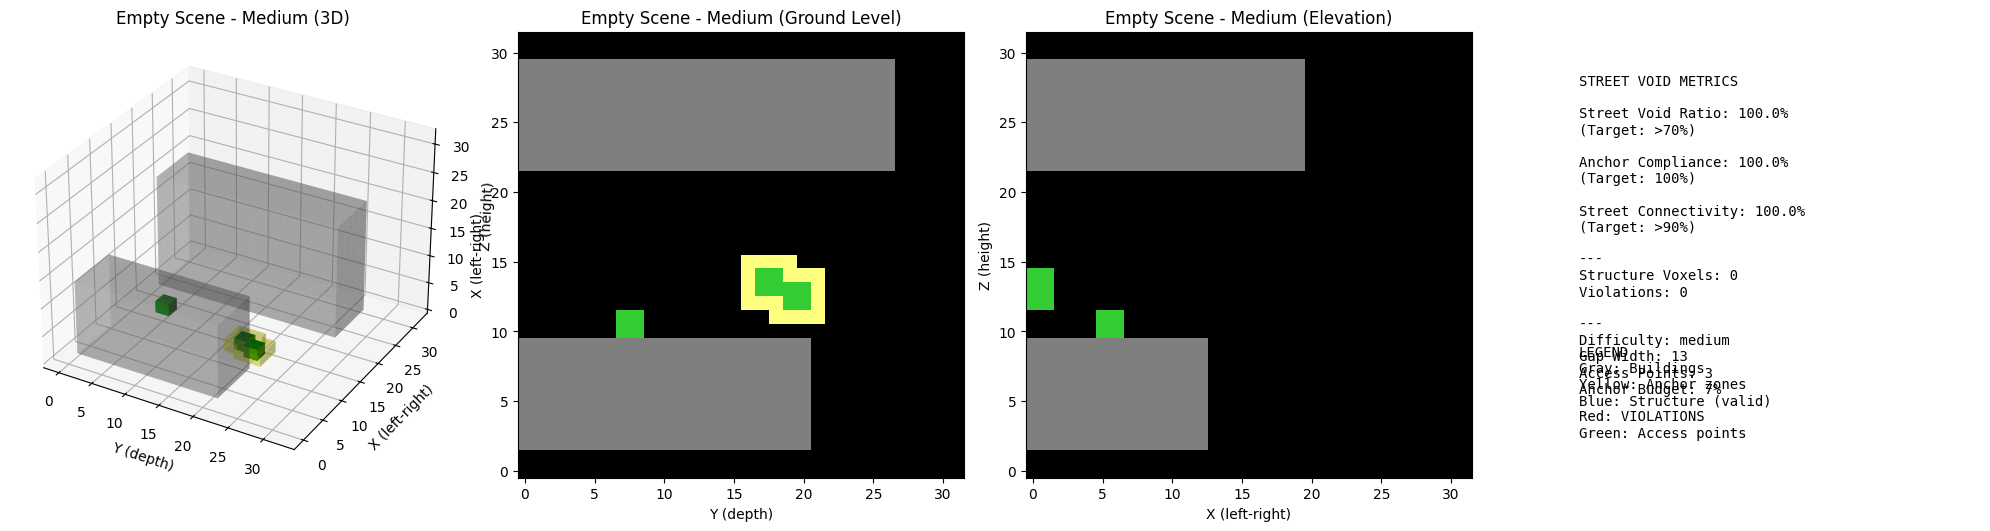

{'void_ratio': 1.0,
 'anchor_compliance': 1.0,
 'connectivity': 1.0,
 'structure_count': np.int64(0),
 'violation_count': np.int64(0)}

In [11]:
# Test with different difficulties
print('\nMedium difficulty scene:')
med_scene, med_meta = scene_gen.generate('medium', device)
visualize_scene(med_scene, CONFIG, med_meta, 'Empty Scene - Medium')


Hard difficulty scene:


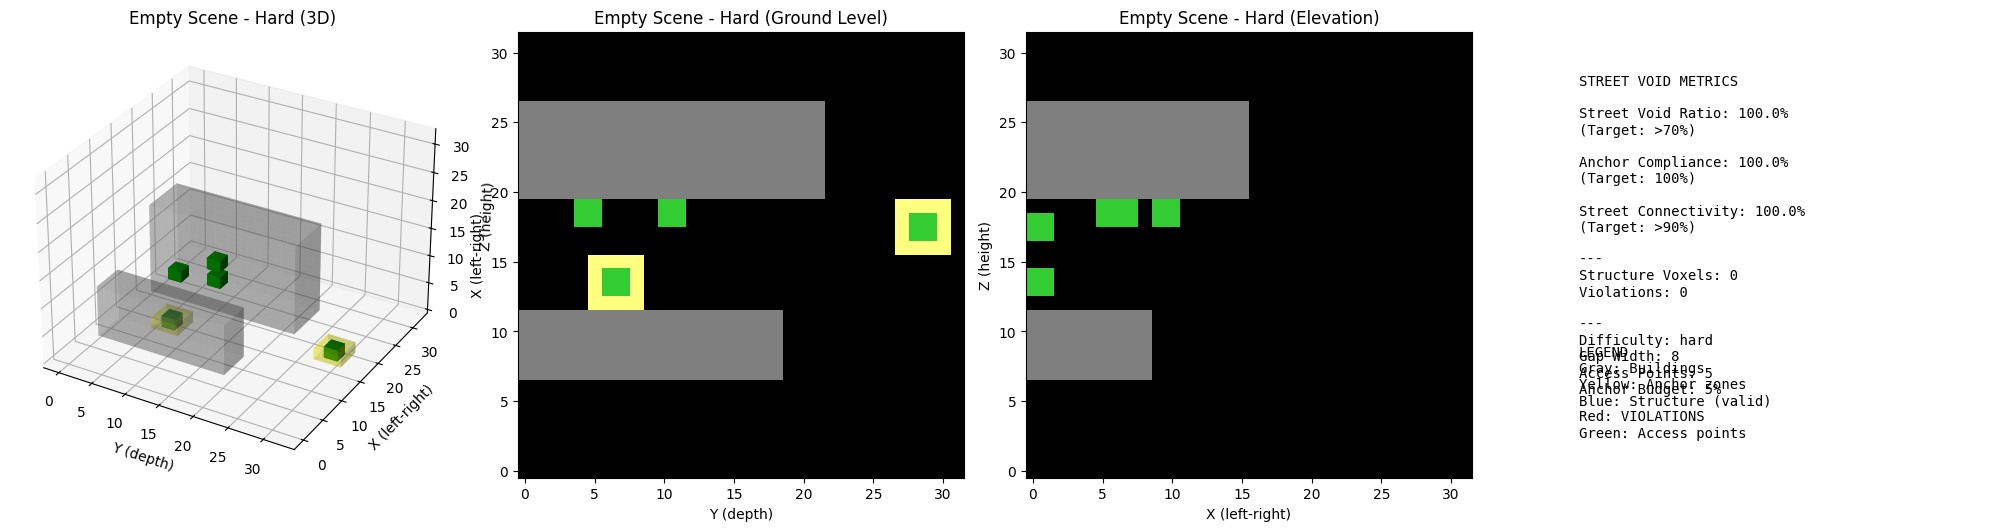

{'void_ratio': 1.0,
 'anchor_compliance': 1.0,
 'connectivity': 1.0,
 'structure_count': np.int64(0),
 'violation_count': np.int64(0)}

In [12]:
print('\nHard difficulty scene:')
hard_scene, hard_meta = scene_gen.generate('hard', device)
visualize_scene(hard_scene, CONFIG, hard_meta, 'Empty Scene - Hard')

## 8. Gradient Flow Verification

In [13]:
print('Verifying gradient flow...')

model = UrbanPavilionNCA(CONFIG).to(device)
model.train()

# Generate test scene
scene, _ = scene_gen.generate('easy', device)

# Forward pass
output = model(scene, steps=10)

# Compute dummy loss
structure = output[:, CONFIG['ch_structure']]
loss = structure.mean()

# Backward pass
loss.backward()

# Check gradients
has_grad = True
for name, param in model.named_parameters():
    if param.grad is None:
        print(f'  WARNING: No gradient for {name}')
        has_grad = False
    elif param.grad.abs().max() == 0:
        print(f'  WARNING: Zero gradient for {name}')
        has_grad = False

if has_grad:
    print('  ✓ All parameters have non-zero gradients')

# Print gradient stats
print('\nGradient statistics:')
for name, param in model.named_parameters():
    if param.grad is not None:
        grad_norm = param.grad.norm().item()
        print(f'  {name}: norm={grad_norm:.6f}')

Verifying gradient flow...

Gradient statistics:
  update_net.0.weight: norm=0.000000
  update_net.0.bias: norm=0.000000
  update_net.2.weight: norm=0.000000
  update_net.2.bias: norm=0.000000
  update_net.4.weight: norm=0.000000
  update_net.4.bias: norm=0.000000


## 9. Test NCA Growth (Before Training)

Testing NCA growth (untrained model)...

After 10 steps:


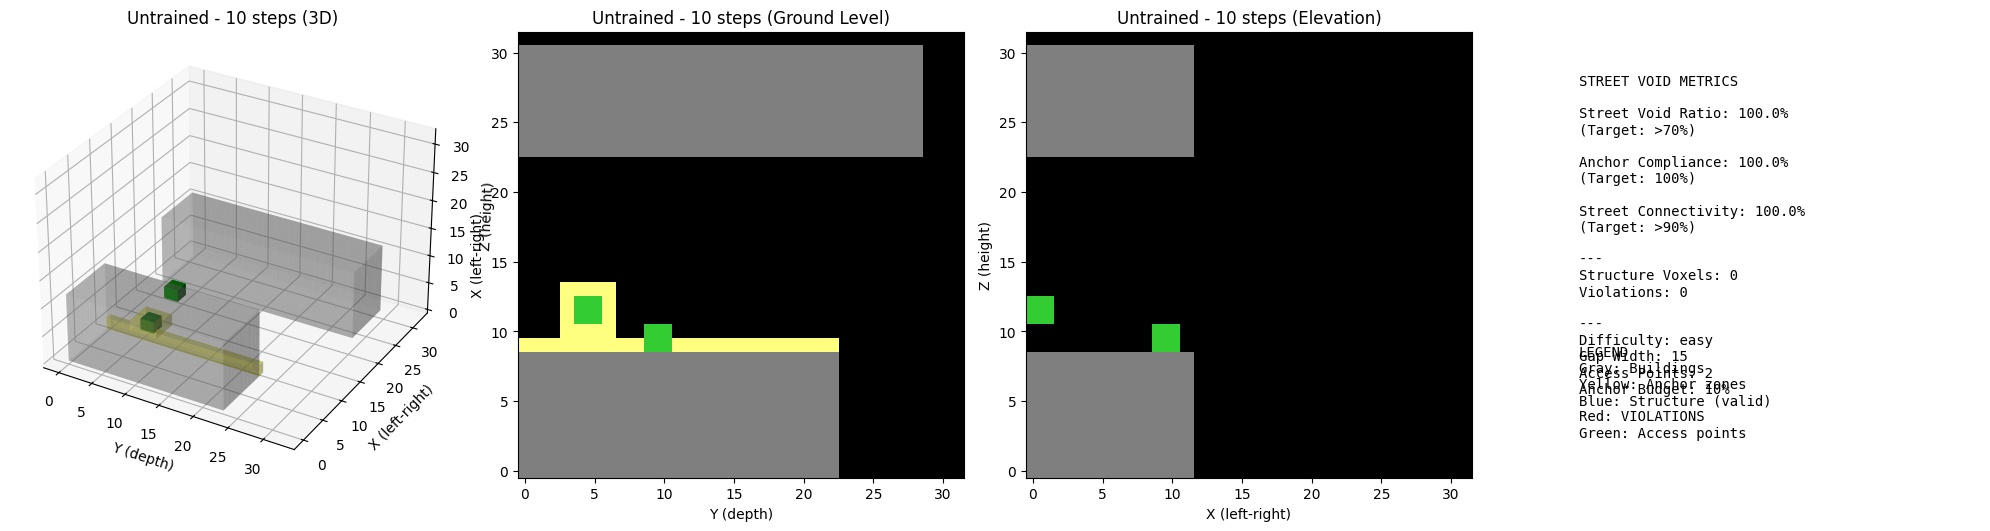


After 30 steps:


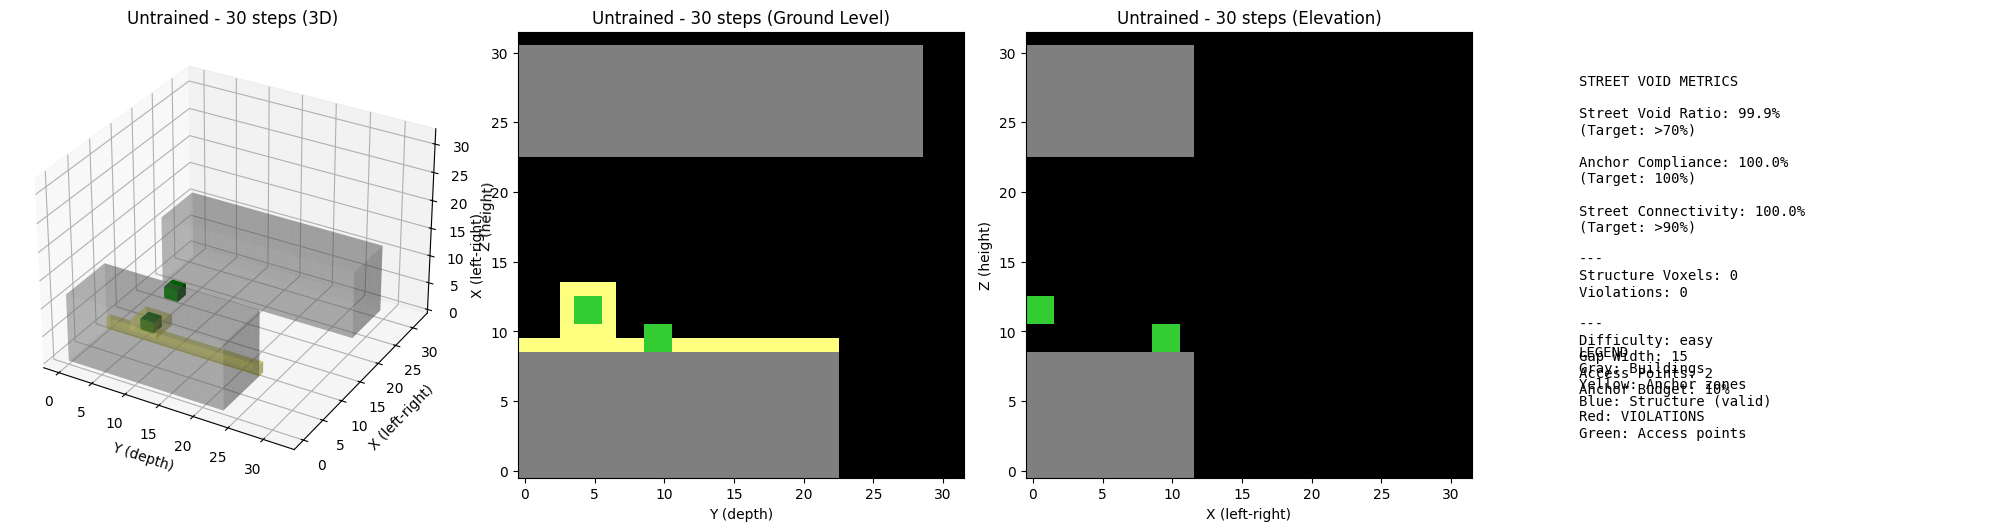


After 50 steps:


In [ ]:
print('Testing NCA growth (untrained model)...')

model = UrbanPavilionNCA(CONFIG).to(device)
scene, meta = scene_gen.generate('easy', device)

# Grow for different step counts
for steps in [10, 30, 50]:
    grown = model.grow(scene, steps=steps)
    print(f'\nAfter {steps} steps:')
    visualize_scene(grown, CONFIG, meta, f'Untrained - {steps} steps')

## 10. Save Foundation Components

In [ ]:
# Save untrained model as foundation checkpoint
foundation_path = f'{PROJECT_ROOT}/step_b/checkpoints/foundation_v2.0.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'version': '2.0',
}, foundation_path)

print(f'Foundation checkpoint saved to {foundation_path}')

## Summary

### What was implemented:

1. **Revised Channel Architecture (8 channels)**
   - ch_0: Ground plane (frozen)
   - ch_1: Existing buildings (frozen)
   - ch_2: Access points (frozen)
   - ch_3: **Anchor zones** (frozen) - NEW
   - ch_4: Structure (grown)
   - ch_5: Surface type (grown)
   - ch_6: Alive state (grown)
   - ch_7: Hidden (grown)

2. **Perceive3D with replicate padding** - Eliminates boundary bias

3. **UrbanPavilionNCA** - No walkable channel, exclusion mask for buildings

4. **UrbanSceneGenerator with anchor zones**
   - Anchor zones generated around access points and along facades
   - Anchor budget limits total anchor area
   - Difficulty levels: easy (10%), medium (7%), hard (5%)

5. **Street void utilities**
   - `compute_street_void_ratio()` - How much street is empty
   - `compute_anchor_compliance()` - Is structure only in anchors
   - `compute_street_connectivity()` - Is void connected

6. **Visualization** - Shows violations, anchor zones, void metrics

### Key differences from Step A:

| Aspect | Step A | Step B |
|--------|--------|--------|
| Walkable | Grown channel | Computed from void |
| Ground contact | Free | Restricted to anchors |
| Anchor zones | None | Explicit frozen channel |
| Visualization | Shows walkable | Shows violations |

### Success criteria met:

- [x] Model produces correct shape
- [x] Anchor zones correctly generated
- [x] Street void computation works
- [x] Visualization shows void/violation
- [x] Gradients flow through all parameters

### Next: NB02_AllConstraints

Implement all loss functions and train with all constraints from epoch 0.

---

*NB01_Foundation_v2.0 - Step B - December 2025*